In [1]:
using Gurobi
using JuMP, GLPK, Mosek
using MosekTools
using VoronoiCells, GeometryBasics, Plots
using Random
using Statistics
using Distributions
using StatsBase

In [20]:
function get_cost_matrix(x, y, norm=2)    
    m = size(x)[1]
    n = size(y)[1]
    #Calculo los costos Cij = |xi-yj| (distancia euclidea en R^2)
    c1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^norm
    c2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^norm
    return (c1+c2).^(1/norm)
end

function plot_locations(x, title)
    
    gr()
    Plots.GRBackend()
    
    m = size(x)[1]
    
    X = x[:,1]
    Y = x[:,2]
    
    scatter(X, Y, aspect_ratio=:equal, markersize = 3, xlim = (-0.1, 1.1), ylim = (-0.1, 1.1), title = title, legend = false)
    
end

function plot_stations(y, title)
   
    plot_locations(y, title)
    
    n = size(y)[1];
    
    points = [Point2(y[i,1], y[i,2]) for i in 1:n];
    
    scatter!(y[:,1], y[:,2], markersize = 6, label = "Stations", markershape = :star) # Plot Stations
    annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) # Add Station Number
    
end

function plot_assignments(x, y, Pi, voronoi = true)
    gr()
    Plots.GRBackend()

    # Define m and n
    m = size(x)[1]
    n = size(y)[1]

    # Create Stations List
    points = [Point2(y[i,1], y[i,2]) for i in 1:n] 

    # Voronoi Cells
    rect = Rectangle(Point2(0, 0), Point2(1, 1))
    tess = voronoicells(points, rect);
        
    if voronoi == true
#         plot(tess, color = :green, alpha = 0.4)
    end

    #Assigments
    assigned_index = [argmax(Pi[i,:]) for i in 1:m];
    
    #Array of arrays. Each array is the amount of cars that go on a particular station
    X = [ x[findall(x->x==i, assigned_index),1] for i in 1:n];
    Y = [ x[findall(x->x==i, assigned_index),2] for i in 1:n];

    for i = 1:n
        scatter!(X[i], Y[i], aspect_ratio=:equal, markersize = 3, legend = false, labels = "Assigned to $i") # Plot EVs (differente color by each Station)
    end
        
#     for i=1:m
#         plot!([x[i,1],y[assigned_index[i],1]],[x[i,2],y[assigned_index[i],2]],color=:black, alpha = 0.2, labels = "") 
#     end
    
    scatter!(y[:,1], y[:,2], markersize = 8, label = "Stations", markershape = :star, color=:white) # Plot Stations
#     annotate!([(points[i][1] + 0.04, points[i][2] + 0.00, text(i, :black)) for i in 1:n]) # Add Station Number
end

function delete_row(matrix, row_index)
    
    return matrix[setdiff(1:end, row_index), :];
    
end

function random_points(size, dx, dy)
   
    rand_x = rand(dx, (size,1))
    rand_y = rand(dy, (size,1))
    
    random_point = hcat(rand_x, rand_y);
    
    return random_point;
    
end

function Geneterate_Ev_distribution(m, congestion_centers)
    
    #Random.seed!(40)

    x = [0 0]
    
    for congestion_point in congestion_centers
    
        mean_x = congestion_point[1];
        mean_y = congestion_point[2];
        variance_x = congestion_point[3];
        variance_y = congestion_point[4];
        amount_of_evs = Int(m * (congestion_point[5] / 100));

        dx = Distributions.Normal(mean_x, variance_x)
        dy = Distributions.Normal(mean_y, variance_y)

        new_points = random_points(amount_of_evs, dx, dy)

        x = vcat(x, new_points)  

    end

    x = delete_row(x, 1);
    
    return sortslices(x, dims = 1);
    
end

function Solve_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)
    
#   println("Dual: ", dual.(Pi))

    
end

function Print_Model(C, s_max)
    
    m = size(C)[1];
    n = size(C)[2];
   
    model = JuMP.Model(GLPK.Optimizer)
        
    @variable(model,Pi[1:m,1:n]>=0)
    
    p = sum(Pi, dims=2);
    s = sum(Pi, dims=1);

    @constraint(model, p .== q)
    @constraint(model, con, s .- s_max .<= zeros(1,n)) 

    @objective(model, Min, sum( C.*Pi ))

    optimize!(model)   
    
    println(dual.(con))

    Pi = value.(Pi) 
    
    plot_assignments(x, y, Pi)

    
end

Print_Model (generic function with 1 method)

# Evs location

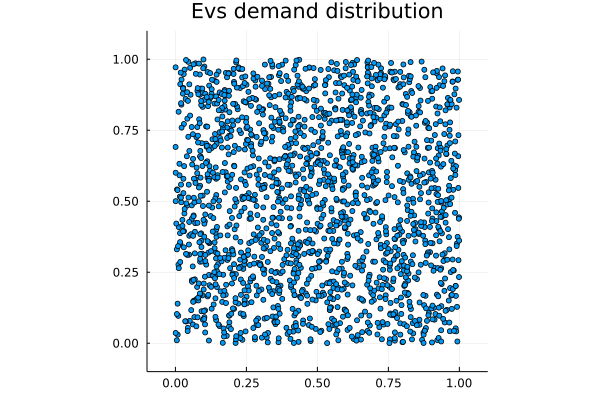

In [22]:
m = 1800
x = rand(m,2)
plot_locations(x, "Evs demand distribution")

# Stations locations

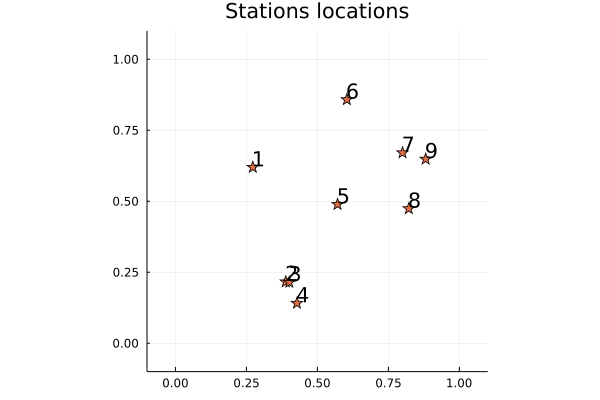

In [18]:
Random.seed!(24)
Random.seed!(9)

d = Distributions.Normal(0.5, 0.22)

n = 9;

y = sortslices(rand(d, (n,2)), dims = 1);

plot_stations(y, "Stations locations")

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


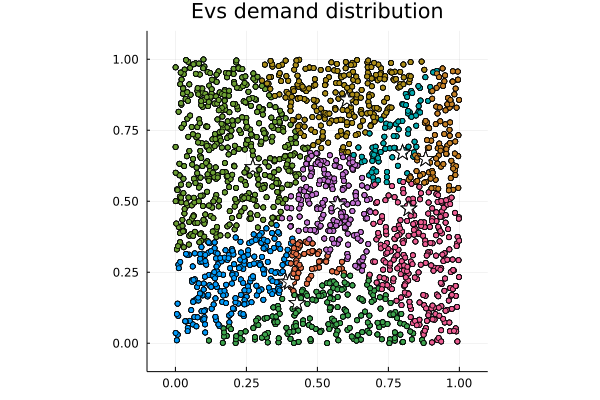

In [26]:
s_max = 5000 * ones(1, n);
q = ones(m,1);
norm = 2
C = get_cost_matrix(x, y, norm);
s = Print_Model(C, s_max)
# savefig("plot.pdf")